# IMDB Sentiment

## 1. Overview
* It seems HELLO WORLD program for Keras community.
* Tested multiple activation functions and RNN architectures to differentiate the performance.
* Performed preprocessing data analysis to
    * Identify optimal sequence length to estimate a max_len.
    * Look for unique words in a dataset.
    * Check common words after embedding in training and testing. 

## 2. Dataset

### 2.1 Load most frequently appeared 10000 words

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

# As imdb.load_data() gave an error, found in stackoverflow following suggestions
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

print("INFO: Loading imdb dataset...")
(data_train, value_train), (data_test, value_test) = imdb.load_data(path="imdb.npz", num_words=10000)
print("INFO: # of training sequences %d" %len(data_train))
print("INFO: # of testing sequences %d" %len(data_test))

# restore np.load for normal use
np.load = np_load_old

Using TensorFlow backend.


INFO: Loading imdb dataset...
INFO: # of training sequences 25000
INFO: # of testing sequences 25000


## Matplotlib setup

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

### 2.2 Compute sequence length distribution

In [3]:
ts_row_length = [len(ts_each_row) for ts_each_row in data_train]
print("Mean and Std. dev. (training) %0.2f, %0.2f" %(np.mean(ts_row_length), np.std(ts_row_length)))
ts_row_length = [len(ts_each_row) for ts_each_row in data_test]
print("Mean and Std. dev. (testing) %0.2f, %0.2f" %(np.mean(ts_row_length), np.std(ts_row_length)))

Mean and Std. dev. (training) 238.71, 176.49
Mean and Std. dev. (testing) 230.80, 169.16


### 2.3 Dissect the dataset

In [4]:
num_total_words  = len(np.hstack(data_train))
num_unique_words = len(np.unique(np.hstack(data_train)))
print("# of word %d and %d are unique in training" %(num_total_words, num_unique_words))

num_total_words=len(np.hstack(data_test))
num_unique_words=len(np.unique(np.hstack(data_test)))
print("# of word %d and %d are unique in testing" %(num_total_words, num_unique_words))
print("")

# of word 5967841 and 9998 are unique in training
# of word 5770105 and 9951 are unique in testing



### 2.4 Count positive and negative labels

In [5]:
labels, counts = np.unique(value_train, return_counts=True)
print("Training:")
print("---------")
for st_label, in_count in zip(labels, counts):
  print("Label {} = {}".format(st_label, in_count))
print("")

labels, counts = np.unique(value_test, return_counts=True)
print("Testing:")
print("--------")
for st_label, in_count in zip(labels, counts):
  print("Label {} = {}".format(st_label, in_count))
print("")

Training:
---------
Label 0 = 12500
Label 1 = 12500

Testing:
--------
Label 0 = 12500
Label 1 = 12500



###  2.5 Identify any words common in training and testing

In [6]:
ts_train_len = [len(ts_each_row) for ts_each_row in data_train]
ts_test_len  = [len(ts_each_row) for ts_each_row in data_test]

in_found = 0
for in_train_idx, in_train_len in enumerate(ts_train_len):
    ts_found_idxs = [in_test_idx for in_test_idx, in_test_len in enumerate(ts_test_len) 
                     if in_test_len == in_train_len]
    for in_found_idx in ts_found_idxs:
        if np.array_equal(data_train[in_train_idx],data_test[in_found_idx]):
            in_found = in_found + 1
if in_found > 0: print("%d are common in both" %in_found) 

123 are common in both


### 2.6 Padding 

Based on mean and standard deviation, maxlen 400 would maintain good balance between trimming and padding zero in the sequence. This is approximately one standard deviation above mean. With the value for maxlen, here are the tensor dimensions used.

In [7]:
in_max_len = 400
data_train = sequence.pad_sequences(data_train, maxlen=in_max_len)
data_test = sequence.pad_sequences(data_test, maxlen=in_max_len)
print("INFO: train shape ", data_train.shape)
print("INFO: test shape  ", data_test.shape)

INFO: train shape  (25000, 400)
INFO: test shape   (25000, 400)


## 3. RNN architectures 
* Designed multiple RNN architectures.

In [8]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, LSTM, Dropout, Flatten, Dense, GRU

### 3.1 Simple RNN 

### 3.1.1 Tanh (SimpleRNN) and sigmoid (Dense) activation functions

In [9]:
# Architecture
model = Sequential()
model.add(Embedding(10000, 256))
model.add(SimpleRNN(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Fitting data
RNNLog = model.fit(data_train, value_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.1)

# Testing accuracy of parameters
fo_loss, fo_accuracy = model.evaluate(data_test, value_test, batch_size=128)
print("Loss: %5.3f" %fo_loss)
print("Accuracy: %5.3f" %fo_accuracy)

W0822 18:39:37.190712 140338117453632 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 18:39:37.222454 140338117453632 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 18:39:37.225163 140338117453632 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 18:39:37.580686 140338117453632 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,609,409
Trainable params: 2,609,409
Non-trainable params: 0
_________________________________________________________________


W0822 18:39:38.333113 140338117453632 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 95s 4ms/step - loss: 0.6469 - acc: 0.6180 - val_loss: 0.5341 - val_acc: 0.7252
Epoch 2/10
22500/22500 [==============================] - 71s 3ms/step - loss: 0.4665 - acc: 0.7822 - val_loss: 0.4950 - val_acc: 0.7648
Epoch 3/10
22500/22500 [==============================] - 61s 3ms/step - loss: 0.3470 - acc: 0.8532 - val_loss: 0.4531 - val_acc: 0.8056
Epoch 4/10
22500/22500 [==============================] - 61s 3ms/step - loss: 0.2621 - acc: 0.8924 - val_loss: 0.5244 - val_acc: 0.7828
Epoch 5/10
22500/22500 [==============================] - 61s 3ms/step - loss: 0.1857 - acc: 0.9289 - val_loss: 0.6088 - val_acc: 0.7712
Epoch 6/10
22500/22500 [==============================] - 61s 3ms/step - loss: 0.1100 - acc: 0.9613 - val_loss: 0.6545 - val_acc: 0.7816
Epoch 7/10
22500/22500 [==============================] - 61s 3ms/step - loss: 0.1082 - acc: 0.9588 - val_loss: 0.8707 - val_acc:

W0822 18:50:55.818326 140338117453632 font_manager.py:1282] findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
W0822 18:50:55.835956 140338117453632 font_manager.py:1282] findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
W0822 18:50:55.856209 140338117453632 font_manager.py:1282] findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


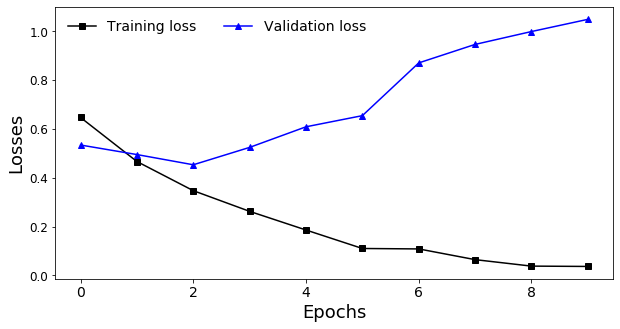

In [10]:
ts_tra_loss = RNNLog.history['loss']
ts_val_loss = RNNLog.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 2)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

### 3.1.2 Relu (RNN) and sigmoid (Dense) activation functions

In [11]:
# Architecture
model = Sequential()
model.add(Embedding(10000, 256))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Fitting data
RNNLog = model.fit(data_train, value_train,
                       epochs=10,
                       batch_size=128,
                       validation_split=0.1)

# Testing accuracy of parameters
fo_loss, fo_accuracy = model.evaluate(data_test, value_test, batch_size=128)
print("Loss: %5.3f" %fo_loss)
print("Accuracy: %5.3f" %fo_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,609,409
Trainable params: 2,609,409
Non-trainable params: 0
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 61s 3ms/step - loss: 5.0603 - acc: 0.5470 - val_loss: 7.8179 - val_acc: 0.5132
Epoch 2/10
22500/22500 [==============================] - 63s 3ms/step - loss: 7.8879 - acc: 0.5058 - val_loss: 7.9421 - val_acc: 0.5024
Epoch 3/10
22500/22500 [==============================] - 81s 4ms/step - 

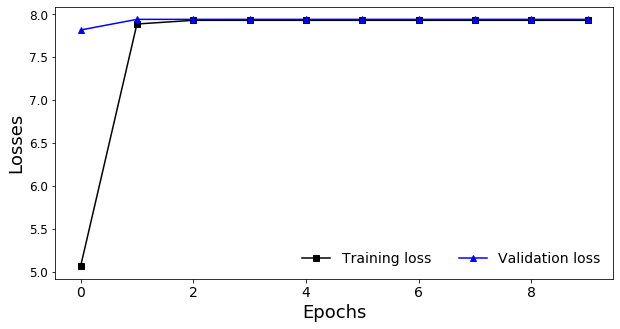

In [12]:
ts_tra_loss = RNNLog.history['loss']
ts_val_loss = RNNLog.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 2)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

### 3.1.3 Sigmoid (RNN) and sigmoid (Dense) activation functions

In [13]:
# Architecture
model = Sequential()
model.add(Embedding(10000, 256))
model.add(SimpleRNN(128, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Fitting data
RNNLog = model.fit(data_train, value_train,
                       epochs=10,
                       batch_size=128,
                       validation_split=0.1)

# Testing accuracy of parameters
fo_loss, fo_accuracy = model.evaluate(data_test, value_test, batch_size=128)
print("Loss: %5.3f" %fo_loss)
print("Accuracy: %5.3f" %fo_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,609,409
Trainable params: 2,609,409
Non-trainable params: 0
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 82s 4ms/step - loss: 0.6642 - acc: 0.5728 - val_loss: 0.6225 - val_acc: 0.6432
Epoch 2/10
22500/22500 [==============================] - 83s 4ms/step - loss: 0.5606 - acc: 0.7028 - val_loss: 0.5538 - val_acc: 0.7160
Epoch 3/10
22500/22500 [==============================] - 83s 4ms/step - 

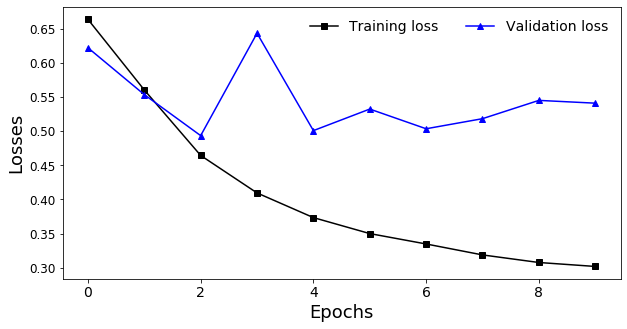

In [14]:
ts_tra_loss = RNNLog.history['loss']
ts_val_loss = RNNLog.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 2)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

### 3.1.4 Summary

Two experiments showed that lost function is not converged between training and validation datasets. It seems longer simulation is required with more epochs to get a good fit model. The accuracy obtained on independent dataset are 75% (tanh) and 77% (sigmoid) using similar architecture. The performance of relu activation was the worst (50% on independent dataset). Due to the worst performance, relu activation is excluded for the further test.   

### 3.2 Long short-term memory (LSTM)

Similarly, LSTM layer was tested with different activation functions. 

### 3.2.1 Tanh (LSTM) and sigmoid (Dense) activation functions

In [15]:
# Architecture
model = Sequential()
model.add(Embedding(10000, 256))
model.add(LSTM(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Fitting data
LSTMLog = model.fit(data_train, value_train,
                       epochs=10,
                       batch_size=128,
                       validation_split=0.1)

# Testing accuracy of parameters
fo_loss, fo_accuracy = model.evaluate(data_test, value_test, batch_size=128)
print("Loss: %5.3f" %fo_loss)
print("Accuracy: %5.3f" %fo_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 2,757,249
Trainable params: 2,757,249
Non-trainable params: 0
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 275s 12ms/step - loss: 0.4912 - acc: 0.7674 - val_loss: 0.4468 - val_acc: 0.8036
Epoch 2/10
22500/22500 [==============================] - 272s 12ms/step - loss: 0.3139 - acc: 0.8737 - val_loss: 0.3217 - val_acc: 0.8612
Epoch 3/10
22500/22500 [==============================] - 277s 12ms/s

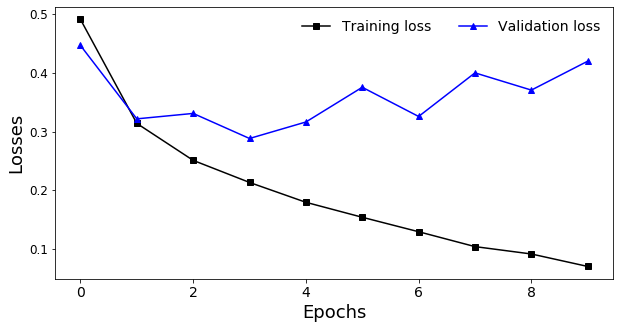

In [16]:
ts_tra_loss = LSTMLog.history['loss']
ts_val_loss = LSTMLog.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 2)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

### 3.2.2 Sigmoid (LSTM) and sigmoid (Dense) activation functions

In [17]:
# Architecture
model = Sequential()
model.add(Embedding(10000, 256))
model.add(LSTM(128, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Fitting data
LSTMLog = model.fit(data_train, value_train,
                       epochs=10,
                       batch_size=128,
                       validation_split=0.1)

# Testing accuracy of parameters
fo_loss, fo_accuracy = model.evaluate(data_test, value_test, batch_size=128)
print("Loss: %5.3f" %fo_loss)
print("Accuracy: %5.3f" %fo_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,757,249
Trainable params: 2,757,249
Non-trainable params: 0
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 272s 12ms/step - loss: 0.6001 - acc: 0.6572 - val_loss: 0.4727 - val_acc: 0.7784
Epoch 2/10
22500/22500 [==============================] - 269s 12ms/step - loss: 0.4049 - acc: 0.8224 - val_loss: 0.3629 - val_acc: 0.8396
Epoch 3/10
22500/22500 [==============================] - 267s 12ms/s

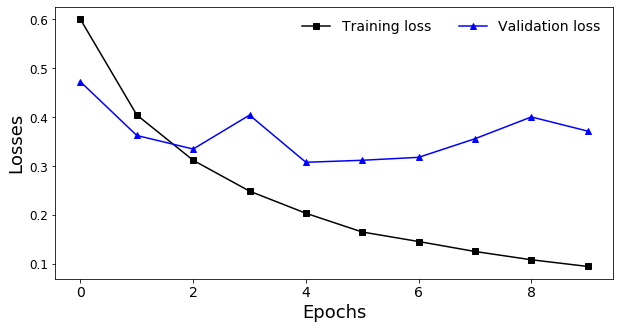

In [18]:
ts_tra_loss = LSTMLog.history['loss']
ts_val_loss = LSTMLog.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 2)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

### 3.2.3 Summary

LSTM with two activation functions had identical performance when accuracy of testing dataset was compared. But, this performance is improved over the result obtained using RNNSimple layer. The difference in losses from training and validation dataset implies that the model is overfitted.

### 3.3 Gated Recurrent Unit (GRU)

Similar to LSTM, GRU was tested  with two activation functions with same parameter as in LSTM layers.

### 3.3.1 tanh (GRU) and sigmoid (Dense) activation functions

In [19]:
# Architecture
model = Sequential()
model.add(Embedding(10000, 256))
model.add(GRU(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Fitting data
GRULog = model.fit(data_train, value_train,
                       epochs=10,
                       batch_size=128,
                       validation_split=0.1)

# Testing accuracy of parameters
fo_loss, fo_accuracy = model.evaluate(data_test, value_test, batch_size=128)
print("Loss: %5.3f" %fo_loss)
print("Accuracy: %5.3f" %fo_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               147840    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,707,969
Trainable params: 2,707,969
Non-trainable params: 0
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 223s 10ms/step - loss: 0.5458 - acc: 0.7598 - val_loss: 0.4252 - val_acc: 0.8064
Epoch 2/10
22500/22500 [==============================] - 221s 10ms/step - loss: 0.3234 - acc: 0.8687 - val_loss: 0.3733 - val_acc: 0.8352
Epoch 3/10
22500/22500 [==============================] - 221s 10ms/s

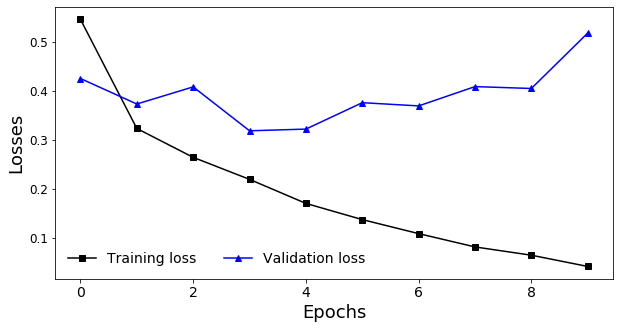

In [20]:
ts_tra_loss = GRULog.history['loss']
ts_val_loss = GRULog.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 2)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

### 3.3.2 Sigmoid (GRU) and sigmoid (Dense) activation functions

In [21]:
# Architecture
model = Sequential()
model.add(Embedding(10000, 256))
model.add(GRU(128, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Fitting data
GRULog = model.fit(data_train, value_train,
                       epochs=10,
                       batch_size=128,
                       validation_split=0.1)

# Testing accuracy of parameters
fo_loss, fo_accuracy = model.evaluate(data_test, value_test, batch_size=128)
print("Loss: %5.3f" %fo_loss)
print("Accuracy: %5.3f" %fo_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               147840    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,707,969
Trainable params: 2,707,969
Non-trainable params: 0
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 224s 10ms/step - loss: 0.6089 - acc: 0.6547 - val_loss: 0.4001 - val_acc: 0.8484
Epoch 2/10
22500/22500 [==============================] - 220s 10ms/step - loss: 0.2900 - acc: 0.8795 - val_loss: 0.2561 - val_acc: 0.9036
Epoch 3/10
22500/22500 [==============================] - 221s 10ms/s

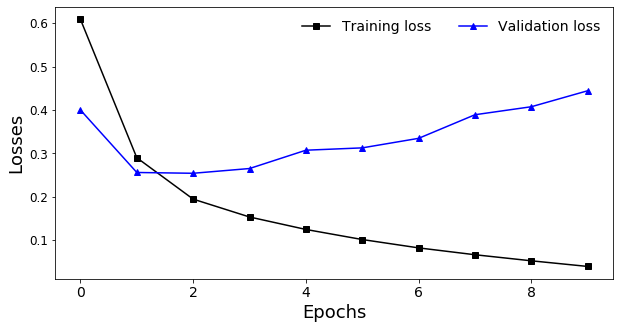

In [22]:
ts_tra_loss = GRULog.history['loss']
ts_val_loss = GRULog.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 2)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

### 3.3.3 Summary

Both activation functions have significantly high loss values for validation dataset within 10 epochs. This indicates that loss functions for training and validating will not coverge soon and this model is also overfitted. Depsite the diverged loss values, accuracy for test dataset was obtained 87%.


## 3.4 Final Remark

Among three tested layers with two activation functions, the accuracy obtained from LSTM and GRU layers for both activation functions are high compared with SimpleRNN but are indistinguishable between them. The challenge of these models is to avoid overfitting. Notably, loss function over epochs reach to the same level at certain epoch, but their convergence is not continued afterward.  